<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/eda_nytimes-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining NYTimes data with county census and geoson data

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

import seaborn as sns
import altair as alt
from altair import datum

from scipy.signal import savgol_filter

from urllib.request import urlopen
import json

from time import time
from datetime import datetime, timedelta
from pytz import timezone

import matplotlib.pyplot as plt

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [2]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [3]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [4]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385985 entries, 0 to 385984
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    385985 non-null  datetime64[ns]
 1   county  385985 non-null  category      
 2   state   385985 non-null  category      
 3   fips    382110 non-null  category      
 4   cases   385985 non-null  int32         
 5   deaths  385985 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 7.3 MB


# import census and GeoJSON data

We want to calculate ratios comparing the number of cases (or deaths) to the population and/or area of the county. Since the population density varies wildly per county, relying on just the absolute number of reported cases could be misleading.

In [5]:
with open('data/county_json2.json') as f:
    county_json2 = json.load(f)

In [6]:
pop_df_ac = optimize(pd.read_csv('data/pop_df_ac.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(pop_df_ac.shape)
pop_df_ac.head()

(3145, 46)


,state,county,total_pop,fips,white,black,asian,hispanic,area,lon,...,per_no_hs,per_some_hs,per_hs,per_associates,per_bachelors,per_graduate,per_college,per_gop,gop,cluster
0,Alabama,Autauga,55869,01001,41215,11098,646,1671,594.435974,-86.641197,...,0.025722,0.087392,0.326078,0.080665,0.158828,0.118065,0.357558,0.754018,True,8
1,Alabama,Baldwin,223234,01003,185747,19215,2346,10534,1589.784058,-87.723953,...,0.027063,0.070291,0.276068,0.093606,0.207029,0.106430,0.407064,0.798123,True,5
2,Alabama,Barbour,24686,01005,11235,11807,116,1117,884.875977,-85.389244,...,0.081990,0.187696,0.356903,0.070379,0.077973,0.044186,0.192538,0.528359,True,0
3,Alabama,Bibb,22394,01007,16663,4719,46,623,622.581970,-87.124962,...,0.057224,0.110710,0.473447,0.057541,0.075856,0.039037,0.172433,0.782270,True,1
4,Alabama,Blount,57826,01009,50176,872,163,5582,644.776001,-86.569756,...,0.074873,0.123502,0.340399,0.120499,0.081182,0.045247,0.246928,0.913855,True,7


In [7]:
pop_df_ac.sort_values(by='total_pop').iloc[[0, -1]]

,state,county,total_pop,fips,white,black,asian,hispanic,area,lon,...,per_no_hs,per_some_hs,per_hs,per_associates,per_bachelors,per_graduate,per_college,per_gop,gop,cluster
548,Hawaii,Kalawao,86,15005,23,0,7,1,11.991000,-156.951126,...,0.043478,0.086957,0.275362,0.173913,0.188406,0.057971,0.420290,0.500000,False,0
204,California,Los Angeles,10039107,06037,2615947,798279,1485197,4881970,4057.884033,-118.224373,...,0.126058,0.087326,0.206922,0.069574,0.206975,0.111115,0.387663,0.246727,False,18


In [8]:
pop_df_ac.sort_values(by='pop_density').iloc[[0, -1]]

,state,county,total_pop,fips,white,black,asian,hispanic,area,lon,...,per_no_hs,per_some_hs,per_hs,per_associates,per_bachelors,per_graduate,per_college,per_gop,gop,cluster
95,Alaska,Yukon-Koyukuk Census Area,5230,02290,1159,42,28,164,145504.78125,-151.390030,...,0.057209,0.086102,0.402774,0.036117,0.075990,0.057787,0.169893,0.334985,False,0
1858,New York,New York,1628706,36061,769099,201829,204096,416759,22.82900,-73.963226,...,0.070018,0.060077,0.124330,0.039753,0.313722,0.294363,0.647838,0.102600,False,23


There are several things to consider:

- Raw numbers will show New York City and Los Angeles County with the highest numbers, all other factors being equal.
- Reporting cases as a percentage (or as we'll use later, a per 100k) would better reflect the severity of infections.
- However, a higher population density would likely make it easier to transmit the disease to another person. Looking at the day-to-day change in new cases could allow us to see how quickly the disease is spreading.

In [9]:
nyt_df = nyt_df[nyt_df['county'] != 'Unknown']
list(set(nyt_df['county']) - set(pop_df_ac['county']))

['Morovis',
 'Sabana Grande',
 'Arecibo',
 'Carolina',
 'Juncos',
 'Canovanas',
 'Catano',
 'Isabela',
 'Camuy',
 'Aguadilla',
 'Manati',
 'Gurabo',
 'Ceiba',
 'Humacao',
 'Jayuya',
 'Yauco',
 'Naranjito',
 'Toa Alta',
 'Tinian',
 'Rincon',
 'Juana Diaz',
 'Las Piedras',
 'Hatillo',
 'Culebra',
 'Maunabo',
 'Lajas',
 'Loiza',
 'Las Marias',
 'Utuado',
 'Saipan',
 'Guanica',
 'Aguada',
 'Aibonito',
 'Arroyo',
 'Cidra',
 'San German',
 'Moca',
 'Aguas Buenas',
 'Vega Baja',
 'Barceloneta',
 'San Sebastian',
 'Naguabo',
 'Maricao',
 'Trujillo Alto',
 'Cabo Rojo',
 'Corozal',
 'Ciales',
 'Anasco',
 'Hormigueros',
 'Dorado',
 'Guaynabo',
 'Coamo',
 'Yabucoa',
 'Barranquitas',
 'St. John',
 'Patillas',
 'Bayamon',
 'Guayama',
 'Penuelas',
 'Vega Alta',
 'Vieques',
 'Salinas',
 'Fajardo',
 'Toa Baja',
 'Cayey',
 'Florida',
 'Santa Isabel',
 'Lares',
 'Quebradillas',
 'San Lorenzo',
 'St. Thomas',
 'Orocovis',
 'Comerio',
 'Mayaguez',
 'Guayanilla',
 'Caguas',
 'Luquillo',
 'Villalba',
 'Ponce

The NYTimes dataset does not include diacritical marks for the names of Puerto Rico's municipios. In the interest of cultural accuracy, we will preserve them when merging with `pop_df`. 

The NYTimes dataset deals with New York City, Kansas City, and Joplin as their own entities. As such, they do not have valid `fips` codes; we must add our custom `fips` from our earlier census EDA.

In [10]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = '36NYC'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = '29KCM'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = '29JOP'
nyt_df['fips'] = nyt_df['fips'].astype('category')

In [11]:
nyt_df[nyt_df['fips']=='36NYC']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,36NYC,1,0
448,2020-03-02,New York City,New York,36NYC,1,0
482,2020-03-03,New York City,New York,36NYC,2,0
518,2020-03-04,New York City,New York,36NYC,2,0
565,2020-03-05,New York City,New York,36NYC,4,0
...,...,...,...,...,...,...
371756,2020-07-26,New York City,New York,36NYC,228445,22956
374968,2020-07-27,New York City,New York,36NYC,228740,22970
378184,2020-07-28,New York City,New York,36NYC,228939,22977
381401,2020-07-29,New York City,New York,36NYC,229237,22982


In [12]:
nyt_df.to_csv('data/nyt_df.csv', index=False)

# merge `nyt_df` and `pop_df` for feature engineering

In [13]:
pop_df_ac[pop_df_ac['state'] == 'Puerto Rico']['county'].unique()

array([], dtype=object)

To reduce the size of the resulting `csv`, we will only merge with the `tot_pop` column to engineer our per capita columns. We can merge with `pop_df` again when plotting our data.

In [14]:
df = nyt_df.merge(
    pop_df_ac[['fips', 'cluster', 'state', 'county']], 
    on='fips', 
    suffixes=('_x','')
)

df = df.drop(['county_x', 'state_x'], axis=1)
df = df.sort_values(by=['date', 'fips'])
print(df.shape)
df.head()

(375167, 7)


,date,fips,cases,deaths,cluster,state,county
0,2020-01-21,53061,1,0,2,Washington,Snohomish
1,2020-01-22,53061,1,0,2,Washington,Snohomish
2,2020-01-23,53061,1,0,2,Washington,Snohomish
192,2020-01-24,17031,1,0,15,Illinois,Cook
3,2020-01-24,53061,1,0,2,Washington,Snohomish


In [15]:
df_clustered = df.groupby(by=['state', 'cluster', 'date']).agg(
    cases=('cases', sum),
    deaths=('deaths', sum)
).dropna().reset_index().astype({'cases': 'int', 'deaths':'int'})

df_clustered.head()

,state,cluster,date,cases,deaths
0,Alabama,0,2020-03-13,1,0
1,Alabama,0,2020-03-14,1,0
2,Alabama,0,2020-03-15,2,0
3,Alabama,0,2020-03-16,3,0
4,Alabama,0,2020-03-17,5,0


In [16]:
pop_df_ac.columns

Index(['state', 'county', 'total_pop', 'fips', 'white', 'black', 'asian',
       'hispanic', 'area', 'lon', 'lat', 'votes_gop', 'votes_dem',
       'total_votes', 'median_income', 'pop25', 'no_hs', 'some_hs', 'hs',
       'some_college', 'associates', 'bachelors', 'graduate', 'never',
       'rarely', 'sometimes', 'frequently', 'always', 'pop_density',
       'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'per_no_hs',
       'per_some_hs', 'per_hs', 'per_associates', 'per_bachelors',
       'per_graduate', 'per_college', 'per_gop', 'gop', 'cluster'],
      dtype='object')

In [17]:
pop_clustered = pop_df_ac.groupby(by=['state', 'cluster'])
wm_pop = lambda x: np.average(x, weights=pop_df_ac.loc[x.index, 'total_pop'])
wm_area = lambda x: np.average(x, weights=pop_df_ac.loc[x.index, 'area'])

pop_df_ac = pop_clustered.agg(
    county=('county', '-'.join),
    total_pop=('total_pop', sum),
    fips=('fips', '-'.join),
    white=('white', sum),
    black=('black', sum),
    asian=('asian', sum),
    hispanic=('hispanic', sum),
    area=('area', sum),
    lon=('lon', wm_area),
    lat=('lat', wm_area),
    votes_gop=('votes_gop', sum),
    votes_dem=('votes_dem', sum),
    total_votes=('total_votes', sum),
    median_income=('median_income', wm_pop),
    pop25=('pop25', sum),
    no_hs=('no_hs', sum),
    some_hs=('some_hs', sum),
    hs=('hs', sum),
    some_college=('some_college', sum),
    associates=('associates', sum),
    bachelors=('bachelors', sum),
    graduate=('graduate', sum),
    never=('never', wm_pop),
    rarely=('rarely', wm_pop),
    sometimes=('sometimes', wm_pop),
    frequently=('frequently', wm_pop),
    always=('always', wm_pop)
).dropna().reset_index()

In [29]:
pop_df_ac[pop_df_ac['fips']=='36NYC'][['never',
       'rarely', 'sometimes', 'frequently', 'always', 'mask']]

,never,rarely,sometimes,frequently,always,mask
356,0.043,0.013,0.066,0.136,0.742,0.8498


In [32]:
pop_df_ac['pop_density'] = pop_df_ac['total_pop'] / pop_df_ac['area']

cols = ['white', 'black', 'asian', 'hispanic', 'total_votes']
for col in cols:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['total_pop']
    
cols2 = ['votes_gop', 'votes_dem']
for col in cols2:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['total_votes']
    
cols3 = ['no_hs', 'some_hs', 'hs', 'some_college', 'associates', 'bachelors', 'graduate']
for col in cols3:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['pop25']

# educational attainment coefficient
pop_df_ac['edu'] = pop_df_ac['per_some_hs'] + 2*pop_df_ac['per_hs'] \
                   + 3*pop_df_ac['per_some_college'] + 4*pop_df_ac['per_associates'] \
                   + 5*pop_df_ac['per_bachelors'] + 6*pop_df_ac['per_graduate']

# mask wearing coefficient
pop_df_ac['mask'] = pop_df_ac['rarely'] + 2*pop_df_ac['sometimes'] \
                   + 3*pop_df_ac['frequently'] + 4*pop_df_ac['always']
    
# pop_df_ac['per_4y'] = (pop_df_ac['bachelors']+pop_df_ac['graduate']) / pop_df_ac['pop25']
# pop_df_ac['per_bhs'] = (pop_df_ac['no_hs']+pop_df_ac['some_hs']) / pop_df_ac['pop25']

pop_df_ac['per_gop'] = pop_df_ac['votes_gop'] / (pop_df_ac['votes_gop'] + pop_df_ac['votes_dem'])
pop_df_ac['gop'] = (pop_df_ac['votes_gop'] > pop_df_ac['votes_dem']).astype(int)

pop_df_ac.head()

,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area,...,per_some_hs,per_hs,per_some_college,per_associates,per_bachelors,per_graduate,edu,mask,per_gop,gop
0,Alabama,0,Barbour-Bullock-Chambers-Coffee-Dale-Geneva-He...,819084.0,01005-01011-01017-01031-01045-01061-01067-0106...,438765.0,309649.0,18560.0,34620.0,8374.217773,...,0.104643,0.292511,0.223988,0.084033,0.150468,0.099015,3.044187,2.984987,0.560388,1
1,Alabama,1,Bibb-Butler-Conecuh-Covington-Crenshaw-Dallas-...,228314.0,01007-01013-01035-01039-01041-01047-01053-0108...,124301.0,92994.0,1145.0,4411.0,9162.385742,...,0.128122,0.411264,0.184188,0.079747,0.087925,0.051869,2.573035,2.824968,0.555708,1
2,Alabama,2,Calhoun-Cherokee-Clay-Cleburne-Coosa-DeKalb-Et...,636595.0,01015-01019-01027-01029-01037-01049-01055-0107...,490272.0,98844.0,4099.0,28554.0,8030.254883,...,0.119780,0.348835,0.225390,0.085182,0.096801,0.060146,2.679226,2.789430,0.764721,1
3,Alabama,3,Jefferson-Madison,1031482.0,01073-01089,566628.0,375094.0,21555.0,46225.0,1912.869019,...,0.067942,0.246644,0.216533,0.082316,0.218741,0.138090,3.462341,3.257701,0.506681,1
4,Alabama,4,Colbert-Fayette-Franklin-Lamar-Lauderdale-Lawr...,588507.0,01033-01057-01059-01075-01077-01079-01093-0110...,439654.0,106409.0,5153.0,24038.0,8166.947266,...,0.103539,0.347946,0.212284,0.075402,0.128120,0.079123,2.853228,2.953270,0.720559,1


In [37]:
pop_df_ac.sort_values(by='mask', ascending=False).head()[['fips', 'never', 'rarely', 'sometimes', 'frequently', 'always', 'mask']]

,fips,never,rarely,sometimes,frequently,always,mask
296,29095-29KAN,0.222512,0.245392,0.258298,0.329870,0.563945,4.007380
46,06033,0.003000,0.004000,0.007000,0.136000,0.849000,3.822000
510,48141,0.007000,0.007000,0.033000,0.075000,0.877000,3.806000
107,10005,0.005000,0.001000,0.035000,0.103000,0.856000,3.804000
352,36069-36123,0.000815,0.010890,0.029520,0.103301,0.855474,3.801728


In [38]:
pop_df_ac['mask'].describe()

count    579.000000
mean       3.250251
std        0.352648
min        2.025470
25%        3.012365
50%        3.305094
75%        3.550097
max        4.007380
Name: mask, dtype: float64

In [34]:
pop_df_ac['edu'].describe()

count    579.000000
mean       3.131300
std        0.375854
min        1.807221
25%        2.878607
50%        3.118265
75%        3.358252
max        4.492079
Name: edu, dtype: float64

In [39]:
df = df_clustered.merge(pop_df_ac, on=['state', 'cluster'], suffixes=('_x',''))
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['total_pop'], axis=0) * 100_000
df = df.sort_values(by=['date', 'fips'])

print(df.shape)
df.head()

(78706, 53)


,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,per_some_college,per_associates,per_bachelors,per_graduate,edu,mask,per_gop,gop,cases_per_100k,deaths_per_100k
74572,Washington,2,2020-01-21,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.258364,0.106655,0.213926,0.105833,3.431124,3.545681,0.417915,0,0.077927,0.0
74573,Washington,2,2020-01-22,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.258364,0.106655,0.213926,0.105833,3.431124,3.545681,0.417915,0,0.077927,0.0
74574,Washington,2,2020-01-23,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.258364,0.106655,0.213926,0.105833,3.431124,3.545681,0.417915,0,0.077927,0.0
24949,Illinois,15,2020-01-24,1,0,Cook,5150233.0,17031,2162156.0,1184247.0,...,0.188318,0.065391,0.226144,0.153550,3.411196,3.539000,0.223595,0,0.019417,0.0
74575,Washington,2,2020-01-24,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.258364,0.106655,0.213926,0.105833,3.431124,3.545681,0.417915,0,0.077927,0.0


In [40]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    return (df, cols_d)

In [41]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7sg = add_savgol_cols(df, new_cols)
df, new_cols_15sg = add_savgol_cols(df, new_cols, window=15)
df, delta_new_cols = add_change_cols(df, new_cols, pre='delta_', clip=False)
df, delta_new_cols_7sg = add_savgol_cols(df, delta_new_cols)
df, delta_new_cols_15sg = add_savgol_cols(df, delta_new_cols, window=15)

print(df.columns)
df.head()

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area', 'lon', 'lat',
       'votes_gop', 'votes_dem', 'total_votes', 'median_income', 'pop25',
       'no_hs', 'some_hs', 'hs', 'some_college', 'associates', 'bachelors',
       'graduate', 'never', 'rarely', 'sometimes', 'frequently', 'always',
       'pop_density', 'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'per_no_hs',
       'per_some_hs', 'per_hs', 'per_some_college', 'per_associates',
       'per_bachelors', 'per_graduate', 'edu', 'mask', 'per_gop', 'gop',
       'cases_per_100k', 'deaths_per_100k', 'new_cases', 'new_deaths',
       'new_cases_per_100k', 'new_deaths_per_100k', 'new_cases_7sg',
       'new_deaths_7sg', 'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg',
       'new_cases_15sg', 'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delt

,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg
74572,Washington,2,2020-01-21,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
74573,Washington,2,2020-01-22,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
74574,Washington,2,2020-01-23,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
24949,Illinois,15,2020-01-24,1,0,Cook,5150233.0,17031,2162156.0,1184247.0,...,0.0,0.0,-0.178571,0.0,-0.003467,0.0,0.025,0.0,0.000485,0.0
74575,Washington,2,2020-01-24,1,0,Island-San Juan-Skagit-Snohomish-Whatcom,1283258.0,53029-53055-53057-53061-53073,917310.0,34921.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0


In [43]:
df.to_csv('data/df.csv', index=False)
pop_df_ac.to_csv('data/pop_df_ac.csv', index=False)

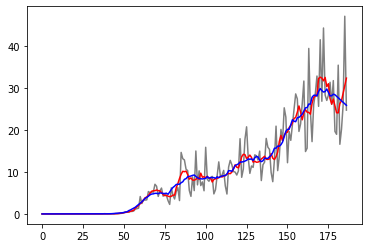

In [26]:
county = 'Los Angeles'
temp_df = df[df['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')

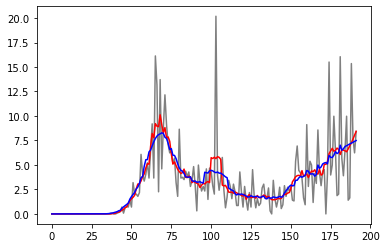

In [27]:
county = 'Island-San Juan-Skagit-Snohomish-Whatcom'
temp_df = df[df['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')